# Entscheider

### Notwendige Importe

In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Daten laden und vorbereiten

In [2]:
data_dir = 'data/flowers'
batch_size = 32
valid_size = 0.2

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([
                                     transforms.RandomRotation(30),
                                     transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor()
                                    ])

test_transforms = transforms.Compose([
                                    transforms.Resize(225),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor()
                                   ])

# Pass transform and get augmanted data here
train_data = datasets.ImageFolder(data_dir+'/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir+'/test', transform=test_transforms)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define sampler for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [3]:
print("Number of training data :", len(train_data))
print("Number of test data     :", len(test_data))

Number of training data : 804
Number of test data     : 66


### Zeigt einige Beispielbilder aus vorbereiteten Daten

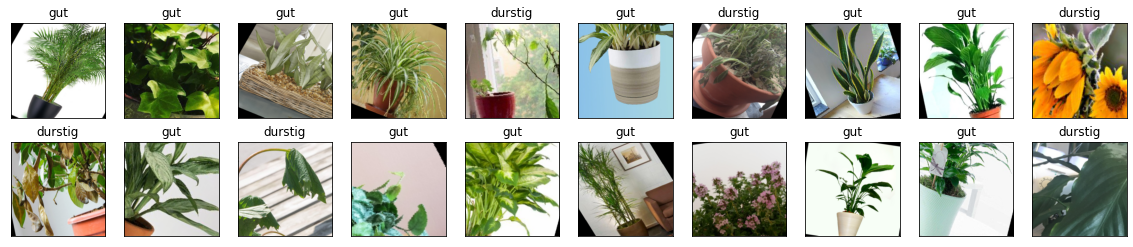

In [4]:
# specify the image classes
classes = ['gut', 'durstig']

# get one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot some images with corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
#     plt.imshow(images[idx])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

Hier sehen wir Beispiele für gute und durstige Blumen

### Vor Trainiertes Modell herunterladen und anzeigen
model : [densenet121](http://pytorch.org/docs/0.3.0/torchvision/models.html#id5)

Dieses Modell besteht aus zwei Hauptteilen, dem Features und dem Klassifikator. Der Featuresteil ist ein Stapel von Convolutional Layer und arbeitet insgesamt als Featuresdetektor. Der Klassifikatorteil ist eine Fully-connected Schicht `(Klassifikator): Linear (in_features=1024, out_features=1000)`. Diese Ebene wurde mit dem ImageNet-Datensatz trainiert, sodass sie für unser spezifisches Problem nicht funktioniert. Das bedeutet, dass wir den Klassifikator ersetzen müssen, aber der Featuresteil werden von alleine perfekt funktionieren.

In [5]:
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Frieren Sie vortrainierte Modelle ein

In [6]:
for param in model.parameters():
    param.requires_grad = False

### Gerät definieren
Wenn eine gültige GPU verfügbar ist, werden wir unser Modell auf der GPU trainieren.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model will work on {device.type}.")

Model will work on cpu.


### Den Klassifikator des vortrainierten Modells für unser Projekt Ändern

In [8]:
model.classifier = nn.Sequential(
                                 nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1)
                                )
# NLLLoss: The negative log likelihood loss.
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

### Trainiere Model

In [104]:
epochs = 10
# count every batch in for loop
steps = 0
# determine when to validate the model
print_every = 10
# save some loss values
running_loss = 0
valid_loss_average_min = np.Inf

for epoch in range(epochs):    
    valid_loss_average = 0.0
    # iterate over train data
    for inputs, labels in train_loader:
        steps += 1
        # move tensors to GPU if CUDA is available
        inputs, labels = inputs.to(device), labels.to(device) 
        # set the gradients to zero.
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logprobs = model.forward(inputs)
        # calculate the batch loss
        batch_loss = criterion(logprobs, labels)
        # compute the gradient
        batch_loss.backward()
        # update parameters
        optimizer.step()
        # add loss item
        running_loss += batch_loss.item()
        # start validation
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            # create a tensor to store comparisons of labels and outputs
            all_equals = torch.empty(0)
            # set dropout and batch normalization layers to evaluation mode
            model.eval()
            # disable gradient calculation
            with torch.no_grad():
                # iterate over validation data
                for inputs, labels in valid_loader:
                    # move tensors to GPU if CUDA is available
                    inputs, labels = inputs.to(device), labels.to(device)
                    # forward pass
                    logprobs = model.forward(inputs)
                    # calculate the batch loss
                    batch_loss = criterion(logprobs, labels)
                    # add valid_loss item
                    valid_loss += batch_loss.item()
                    # change negative probabilities to positive numbers
                    probs = torch.exp(logprobs)
                    # get top probabilities and their indexes
                    top_ps, top_idxes = probs.topk(1, dim=1)
                    # create boolean mask for idxes as True, False format
                    equals = top_idxes == labels.view(*top_idxes.shape)
                    # chage mask into 1,0 format
                    equals = equals.type(torch.FloatTensor).squeeze()
                    # calculate accuracy of batch and add to accuracy
                    accuracy += torch.mean(equals).item()
            valid_loss_average = valid_loss/len(valid_loader)
            # print the evolutions
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {valid_loss_average:.3f}.. "
                  f"Valid accuracy: {accuracy/len(valid_loader):.3f}")
            # reset running loss
            running_loss = 0
            # set dropout and batch normalization layers to training mode
            model.train()
            # save best model
            if valid_loss_average < valid_loss_average_min:
                print('Valid loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                      .format(valid_loss_average_min, valid_loss_average))
                torch.save(model.state_dict(), 'model_290522_2114.pt')
                valid_loss_average_min = valid_loss_average
       

Epoch 1/10.. Train loss: 0.577.. Valid loss: 0.509.. Valid accuracy: 0.800
Valid loss decreased (inf --> 0.509225).  Saving model ...
Epoch 1/10.. Train loss: 0.475.. Valid loss: 0.421.. Valid accuracy: 0.844
Valid loss decreased (0.509225 --> 0.420543).  Saving model ...
Epoch 2/10.. Train loss: 0.498.. Valid loss: 0.489.. Valid accuracy: 0.738
Epoch 2/10.. Train loss: 0.482.. Valid loss: 0.439.. Valid accuracy: 0.787
Epoch 3/10.. Train loss: 0.372.. Valid loss: 0.419.. Valid accuracy: 0.806
Valid loss decreased (0.420543 --> 0.418680).  Saving model ...
Epoch 3/10.. Train loss: 0.377.. Valid loss: 0.366.. Valid accuracy: 0.831
Valid loss decreased (0.418680 --> 0.366427).  Saving model ...
Epoch 4/10.. Train loss: 0.339.. Valid loss: 0.401.. Valid accuracy: 0.819
Epoch 4/10.. Train loss: 0.317.. Valid loss: 0.357.. Valid accuracy: 0.831
Valid loss decreased (0.366427 --> 0.357259).  Saving model ...
Epoch 5/10.. Train loss: 0.373.. Valid loss: 0.389.. Valid accuracy: 0.825
Epoch 5/10

### Lade Model

In [9]:
model.load_state_dict(torch.load('model_290522_2114.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

### Prüfe Das Model

Wir zeigen dem Model während des Trainings keine Testfotos

In [10]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
misspred_pictures = list()

model.eval()
# iterate over test data
for inputs, labels in test_loader:
    # move tensors to GPU if CUDA is available
    inputs, labels = inputs.to(device), labels.to(device)
    # forward pass
    logprobs = model.forward(inputs)
    # calculate the batch loss
    batch_loss = criterion(logprobs, labels)
    # update test loss
    test_loss += batch_loss.item()*inputs.size(0)
    # change negative probabilities to positive numbers
    probs = torch.exp(logprobs)
    # get top probabilities and their indexes
    pr, top_idxes = probs.topk(1, dim=1)
    # create boolean mask for idxes as True, False format
    equals = (top_idxes == labels.view(*top_idxes.shape)).squeeze()    
    # fill class_correct and class_total lists
    for i in range(inputs.size(0)):
        label = labels.data[i]
        class_correct[label] += equals[i].item()
        class_total[label] += 1
    # get misspredicted pictur indexes    
    misspred = (equals == 0).nonzero()
    # save that pictures and their predictions
    for idx in misspred:
        misspred_picture = inputs[idx].numpy().squeeze()        
        prediction = top_idxes[idx].item()
        real = labels[idx].item()
        misspred_pictures.append([misspred_picture, prediction, real, pr[idx].item()])
        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
# print accuracy of each type of inputs
for i in range(2):
    if class_total[i] > 0:
        print(
              f'Test Accuracy of {classes[i]:s}: '
              f'{100 * class_correct[i] / class_total[i]:.2f} '
              f'({np.sum(class_correct[i]):.0f}/{np.sum(class_total[i]):.0f})'
             ) 
    else:
        print(f'Test Accuracy of {classes[i]:s}: N/A (no training examples)')

print(
      f'\nTest Accuracy (Overall): '
      f'{100. * np.sum(class_correct) / np.sum(class_total):.2f}' 
      f'({np.sum(class_correct):.0f}/{np.sum(class_total):.0f})'
     )

Test Loss: 0.249277

Test Accuracy of gut: 96.97 (32/33)
Test Accuracy of durstig: 93.94 (31/33)

Test Accuracy (Overall): 95.45(63/66)


In [11]:
misspred_pictures

[[array([[[0.24705882, 0.2509804 , 0.2509804 , ..., 0.2627451 ,
           0.18039216, 0.6431373 ],
          [0.24705882, 0.24705882, 0.2509804 , ..., 0.26666668,
           0.18039216, 0.6392157 ],
          [0.24313726, 0.24705882, 0.2509804 , ..., 0.27058825,
           0.18431373, 0.6392157 ],
          ...,
          [0.6509804 , 0.6509804 , 0.6509804 , ..., 0.30980393,
           0.30588236, 0.69411767],
          [0.67058825, 0.67058825, 0.6784314 , ..., 0.3137255 ,
           0.29411766, 0.6784314 ],
          [0.60784316, 0.6117647 , 0.6156863 , ..., 0.2901961 ,
           0.28235295, 0.6862745 ]],
  
         [[0.11372549, 0.11764706, 0.11764706, ..., 0.24313726,
           0.16862746, 0.6392157 ],
          [0.11372549, 0.11372549, 0.11764706, ..., 0.24705882,
           0.16862746, 0.6392157 ],
          [0.10980392, 0.11372549, 0.11764706, ..., 0.2509804 ,
           0.17254902, 0.6392157 ],
          ...,
          [0.3529412 , 0.3529412 , 0.35686275, ..., 0.14901961,
  

### Zeige falsch klassifizierte Bilder an

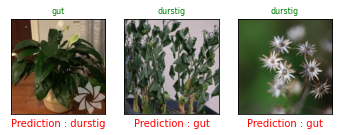

In [12]:
# plot some images with corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for i in range(len(misspred_pictures)):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(misspred_pictures[i][0], (1, 2, 0)))
    ax.set_title(classes[misspred_pictures[i][2]], color='g', fontsize=8)
    plt.xlabel(f"Prediction : {classes[misspred_pictures[i][1]]:^s}", color='r')
    

In [2]:
import captum